# Project Proposal

## Title: Influences of Employee Attrition



## Introduction:


Within the human resources (HR) department of companies, there is a record kept of every employee that has ever worked in said company, some data including their job role, level of education and job satisfaction, to name a few. One of the most important variables that is kept track of in these records is the attrition of the employees, whether or not an employee ended up leaving the company. HR data analysts can compile this data and analyze it to help the management team determine what makes for an ideal employee to hire, and how to retain employees.They can do this by looking at what factors cause employees to stay in the said company and which factors generally cause employees to leave. The data set our group is analyzing is fictional, yet realistic, and was created by an HR data analyst for a company who was interested in determining the factors relating to the employee attrition.  

For our group project, we would like to propose the following research question:

#### “Can we determine whether or not there will be employee attrition based on the hourly rate of pay and time spent working for a company of an employee?”


## Preliminary exploratory data analysis:

Below are the steps to tidying our data by isolating important variables and eliminating irrelevant variables. Since there were no missing data, we did not need to include Na.rm code.  To prevent certain variables from weighing more importance during our k-neighbour analysis, we also standardized the data using the recipe function. 

In [1]:
install.packages("kknn")
library(tidyverse)
library(repr)
library(kknn)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks strin

In [2]:
attrition_data<-read.csv ("https://raw.githubusercontent.com/wenshanli1231/DSCI-Group-Project/main/Employee-Attrition.csv")
attrition_data

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,⋯,2,80,1,6,0,3,6,2,0,3
49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,⋯,4,80,0,17,3,2,9,6,0,8
34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,⋯,1,80,0,6,3,4,4,3,1,2


In [3]:
attrition_data <- attrition_data |>
    select( Attrition, HourlyRate, YearsAtCompany)

attrition_data <- attrition_data |>
        mutate(Attrition = as_factor(Attrition))

In [4]:
attrition_split <- initial_split(attrition_data, prop = 0.75, strata = Attrition)
attrition_train <- training(attrition_split)
attrition_test <- testing(attrition_split) 

In [5]:
set.seed(10)

attrition_recipe <- recipe(Attrition~ HourlyRate + YearsAtCompany, data = attrition_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
    
knn_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
       set_engine("kknn") |>
       set_mode("classification")

attrition_fit <- workflow() |>
       add_recipe(attrition_recipe) |>
       add_model(knn_spec) |>
       fit(data = attrition_train)
attrition_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1743869
Best kernel: rectangular
Best k: 3

### Below is a summary of our tidied Employee Attrition data in one table 

In [6]:
attrition_table <- attrition_train |>
        group_by(Attrition) |>
        summarize( 
            mean_HourlyRate = mean(HourlyRate), 
            mean_YearsAtCompany = mean(YearsAtCompany), 
            count = n(), 
            count_blanks = sum(is.na(Attrition))
        )

attrition_table

Attrition,mean_HourlyRate,mean_YearsAtCompany,count,count_blanks
<fct>,<dbl>,<dbl>,<int>,<int>
Yes,65.35028,4.847458,177,0
No,65.65476,7.483766,924,0


In [ ]:
Below is a scatter plot to 

Attrition,n,percent
<fct>,<int>,<dbl>
Yes,177,16.07629
No,924,83.92371


Attrition,n,percent
<fct>,<int>,<dbl>
Yes,177,16.07629
No,924,83.92371


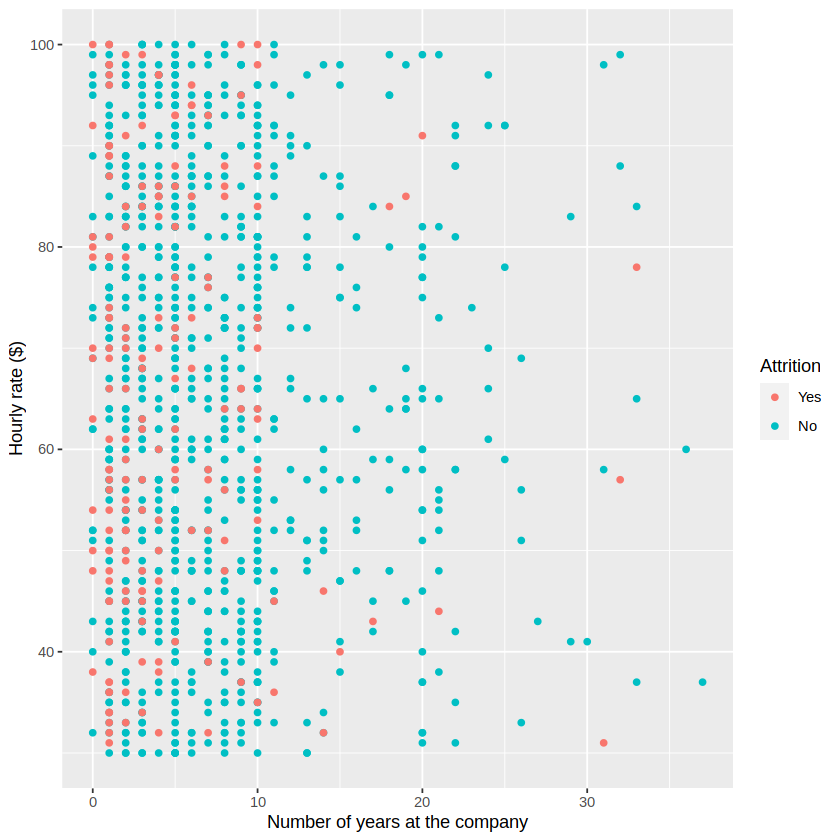

In [7]:
attrition_proportions <- attrition_train |>
                      group_by(Attrition) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(attrition_train))

attrition_proportions

attrition_proportions_train <- attrition_train |>
                      group_by(Attrition) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(attrition_train))

attrition_proportions_train


attrition_plot <- ggplot(attrition_train, aes(x = YearsAtCompany, y = HourlyRate, colour = Attrition)) + 
            geom_point() +
            xlab("Number of years at the company") +
            ylab("Hourly rate ($)")
            
attrition_plot

## Method: 

We will conduct our data analysis by first tidying our data, and then selecting the columns of the variables we are  interested in. The variables we decided to base our analysis on include: the hourly rate earned, years worked at company, 
and attrition. We chose these variables because it would make sense that they could influence employee attrition. For example, the compensation an employee receives for their work could be a reason for them to stay or leave the company  depending on if they are well paid or not. Years worked also seems like a useful variable for prediction because if an employee has been working at the same company for an extended period, that could influence them to stay at the company since they could have friends there or prefer the work environment or benefits there. On the other hand, if someone is still new to the company, they might not be as attached. Our analysis will determine if these variables are actually correlated with attrition and we plan to visualize this through a scatter plot with the years worked and hourly rate on the axis and the points colored by attrition. This way we can try and identify any patterns or trends.



## Expected outcomes and significance:

From this data, we expect to find an association between our established predictor variables and employee attrition, in that there will be less attrition to individuals with a higher hourly rate of pay and larger amount spent working for the company. As previously mentioned in the introduction, data analysis like this can help higher ups in companies make more strategic choices on who the best candidates are to hire and what factors, such as hourly pay and time spent at the company, will influence favourable and strong employees to stay. The opposite is also true, in that this can also determine what might cause poorer performing employees to consider leaving the company and seeking work elsewhere. Future research could explore other categories present in the data, such as level of education, marital status, business traveling, and many more to help create a strong system for determining whether a gold-standard employee will leave the company or stay with the company for a longer period of time.